# Fudan PRML Fall 2024 Exercise 4: Unsupervised Learning

![news](./news.png)

- Name: 杨淳瑜
- Student ID: 22307140114

In this assignment, you will build a **text classification** system which is a fundamental task in the field of Natural Language Processing (NLP). More precisely, you are given a news classification task, assigning given news texts to the categories to which they belong. Unlike traditional classification tasks, **we did not provide you with any labels for this assignment, and you need to find a way to construct labels for these articles**. 

For this assignment you can use commonly used deep learning frameworks like PyTorch. **You can use pretrained word vectors like Glove, but not pretrained large models like BERT.**

# 1. Setup

In [1]:
# setup code
%load_ext autoreload
%autoreload 2
import os
import pickle 
import numpy as np
from sklearn.cluster import KMeans

In [2]:
dataset_path = 'kmeans_news.pkl'

all_data = None
with open(dataset_path,'rb') as fin:
    all_data = pickle.load(fin)
    all_data_np = np.array(all_data)

print ('\n'.join(all_data[0:5]))
print ('Total number of news: {}'.format(len(all_data)))

经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？
颜值很高的她，一双美腿甚至可以让人忽略她的颜值
转自常德诗人”再访桃花源“（再续心灵故乡的故事）
虎牙拼杀四年抢得游戏直播第一股 但真正的挑战才刚开始
如何评价许鞍华导演？她的电影为什么总能给人以触动？
Total number of news: 83360


# 2. Exploratory Data Analysis

Not all data within the dataset is suitable for clustering. You might need to filter and process some of them in advance.

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert list of news articles into a DataFrame for easier manipulation
news_df = pd.DataFrame(all_data, columns=['text'])

# Display basic statistics about the 
print(news_df.head())
print(news_df.describe())

                         text
0   经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？
1     颜值很高的她，一双美腿甚至可以让人忽略她的颜值
2    转自常德诗人”再访桃花源“（再续心灵故乡的故事）
3  虎牙拼杀四年抢得游戏直播第一股 但真正的挑战才刚开始
4   如何评价许鞍华导演？她的电影为什么总能给人以触动？
                     text
count               83360
unique              76120
top     上联：泰山黄山赵本山，如何对下联？
freq                  101


In [4]:
# Remove duplicate rows based on the 'text' column
news_df.drop_duplicates(subset='text', inplace=True)

# Reset the index after removing duplicates
news_df.reset_index(drop=True, inplace=True)

# Display basic statistics after removing duplicates
print(news_df.describe())
print(news_df.head())

                             text
count                       76120
unique                      76120
top     经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？
freq                            1
                         text
0   经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？
1     颜值很高的她，一双美腿甚至可以让人忽略她的颜值
2    转自常德诗人”再访桃花源“（再续心灵故乡的故事）
3  虎牙拼杀四年抢得游戏直播第一股 但真正的挑战才刚开始
4   如何评价许鞍华导演？她的电影为什么总能给人以触动？


In [5]:
# Check for any missing values in the dataset
print("Missing values in the dataset:")
print(news_df.isnull().sum())

Missing values in the dataset:
text    0
dtype: int64


News article length distribution:
count    76120.000000
mean        22.288334
std          7.355647
min          2.000000
25%         17.000000
50%         23.000000
75%         28.000000
max        145.000000
Name: length, dtype: float64


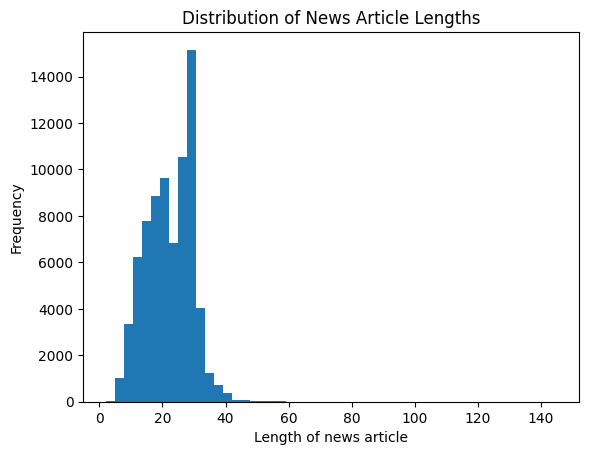

In [6]:
# Check the length of each news article
news_df['length'] = news_df['text'].apply(len)

# Display the distribution of news article lengths
print("News article length distribution:")
print(news_df['length'].describe())

# Visualize the distribution of article lengths
import matplotlib.pyplot as plt
plt.hist(news_df['length'], bins=50)
plt.xlabel('Length of news article')
plt.ylabel('Frequency')
plt.title('Distribution of News Article Lengths')
plt.show()

# 3. Get embeddings for the news

We need to convert the news titles into some kind of numerical representation (embedding) before we can do clustering on them. Below are two ways to get embeddings for a paragraph of text:

1. **Pretrained word embeddings**: You can use pretrained word embeddings like Glove to get embeddings for each word in the news, and then average them (or try some more advanced techniques) to get the news embedding.

2. **General text embedding models**: You can use general text embedding models to get embedding for a sentence directly.

You can choose either of them to convert the news titles into embeddings.

In [7]:
# import numpy as np
# import spacy

# spacy.require_gpu()

# # Load the medium English model with Glove vectors
# nlp = spacy.load('zh_core_web_sm')

# def get_embedding(text):
#     # Returns the average embedding of the text
#     doc = nlp(text)
#     return np.mean([word.vector.get() for word in doc if word.has_vector], axis=0)

# # Apply the function to each news article
# news_df['embedding'] = news_df['text'].apply(get_embedding)

# # Convert the list of embeddings into a numpy array for clustering
# embeddings = np.vstack(news_df['embedding'].values)

# # Now, embeddings can be used for clustering
# print("Shape of embeddings array:", embeddings.shape)


In [8]:
# import torch
# from transformers import AutoTokenizer, AutoModel
# import pandas as pd
# from tqdm import tqdm

# # Load the DataFrame (assuming 'news_df' is already defined)
# # news_df = pd.read_csv('your_file.csv')  # Uncomment if loading from a CSV

# # Load a pre-trained model and tokenizer for Chinese text
# model_name = 'hfl/chinese-roberta-wwm-ext'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name).to('cuda')

# # Function to convert a list of texts to embeddings
# def get_embeddings(texts, batch_size=32):
#     embeddings_list = []
#     for i in tqdm(range(0, len(texts), batch_size)):
#         batch_texts = texts[i:i + batch_size]
        
#         # Tokenize and move inputs to GPU
#         inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')
        
#         # Get embeddings
#         with torch.no_grad():
#             outputs = model(**inputs)
#             embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling over the sequence length
#             embeddings_list.append(embeddings.cpu())
    
#     return torch.cat(embeddings_list, dim=0)

# # Convert the 'text' column to embeddings
# texts = news_df['text'].tolist()
# embeddings = get_embeddings(texts, batch_size=64)

# # Save embeddings as a numpy array if needed
# import numpy as np
# np.save('embeddings.npy', embeddings.numpy())

# print(f"Embeddings shape: {embeddings.shape}")


In [9]:
import torch
import torch.nn as nn
from torchtext import vocab

# Step 1: Load custom word vectors (assuming torchtext < 0.10)
custom_embeddings = vocab.Vectors(name='sgns.sogounews.bigram-char')

d:\Documents\miniconda\envs\nlp-course\Lib\site-packages\torchtext\vocab.py:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.itos, self.stoi, self.vectors, self.dim =

In [10]:
def contains_english(text):
    # Check if any character in the text is an English letter
    return any(char.isascii() and char.isalpha() for char in text)

# Check each key and print those containing English characters
english_found = []
for key in custom_embeddings.stoi.keys():
    if contains_english(key):
        english_found.append(key)

print("Keys containing English characters:")
english_found.sort()
for key in english_found:
    print(key)

print(f"\nTotal keys with English characters: {len(english_found)}")
print(f"Total keys in stoi: {len(custom_embeddings.stoi)}")

Keys containing English characters:
%G
&Oslash
&amp
&gt
&lt
&reg
-BI
-K
-M
-x
-y
A
A-
AA
AAV
AB
ABB
ABC
ABL
ABO
AC
ACCA
ACTH
AD
ADS
AESA
AGM-
AH-
AIM
AIM-
AIMPhoneline
AK
AK-
AM
AMD
AMOS
AMS
AOC
AOL
APPLE
ARJ
ARM
AT&amp
ATI
ATM
ATP
AVS
Access
Actoz
AdCenter
Adobe公司
Alex
Alexa
Amy
Andy
Anita
Apabi
Apusic
ArialNarrow
As
Asianux
Athlon
B
B-
BAE
BBC
BBDC
BBS
BC
BCT
BEA
BITTM
BOSS
BP
BPM
BSP
BT
BTV
Berlintallwall
Bet
Bet&amp
BetEuro
BetOnBet
Beta
Betfair
Betfred
Betsafe
Betway
Block
Borland
BusinessObjects
C
C-
CA
CAD
CATHERINE
CBA
CBD
CCIE
CCTV
CCTV-
CCWResearch
CD
CDC
CDMA
CE
CEO
CEPA
CET
CFO
CG
CH-
CHOP
CIA
CIO
CM
CN
CNET
CNN
CNNIC
CO
COLOR
COM
COO
CP
CPA
CPI
CPU
CRM
CRT
CS
CSK
CT
CTP
CUBA
CWDM
Carter
Cecilla
Cell
Centrebet
Cgogo
China
Chinabyte
Chrysler
Cl
Clever
Co
ColinB
Connie
Conroe
Cool
Core
CoreDuo
Crestor
Currentconfiguration
D
DARPA
DB
DC
DDI
DDR
DELL
DHL
DIY
DJ
DM
DMB
DNA
DOS
DRAM
DSP
DV
DVB-H
DVD
DWDM
Datastream
David
Dell
Diram
Directions
DisplaySearch
Don
Dortmund
Dr
Duo
E
E

In [11]:
num_classes = custom_embeddings.vectors.shape[0]

In [12]:
# Step 2: Create an embedding layer
embedding_layer = nn.Embedding.from_pretrained(
    custom_embeddings.vectors, freeze=True)
print(embedding_layer)

# Step 3: Define a function to convert a sentence to a mean embedding


@torch.no_grad()
def sentence_to_embedding(sentence, char2index, embedding_layer):
    """
    Convert a sentence to a single embedding by averaging word embeddings.
    """
    # Tokenize the sentence (basic tokenization by splitting on spaces)
    tokens = list(sentence)

    # Convert each token to its corresponding index in the vocabulary
    indices = [char2index[token] for token in tokens if token in char2index]

    # If none of the tokens are in the vocabulary, return a zero vector
    if not indices:
        return torch.zeros(embedding_layer.embedding_dim)

    # Convert indices to a tensor
    indices_tensor = torch.tensor(indices)
    # Get the embeddings for each word
    embeddings = embedding_layer(indices_tensor)

    # Calculate the mean of the embeddings (averaging along the sequence dimension)
    mean_embedding = embeddings.mean(dim=0)

    return mean_embedding


# Step 4: Example usage
sentence = "的我爱学习"
embedding = sentence_to_embedding(
    sentence, custom_embeddings.stoi, embedding_layer)
print("Sentence Embedding:", embedding.shape)

Embedding(365113, 300)
Sentence Embedding: torch.Size([300])


In [15]:
from tqdm import tqdm
all_embeddings = []
sentences = news_df['text'].tolist()
for sentence in tqdm(sentences):
    embedding = sentence_to_embedding(sentence, custom_embeddings.stoi, embedding_layer)
    embedding = embedding.cpu().numpy()
    all_embeddings.append(embedding)

embeddings_array = np.stack(all_embeddings)
np.save('pretrained_embeddings.npy', embeddings_array)

100%|██████████| 76120/76120 [00:04<00:00, 17852.80it/s]


# 4. Clustering

Do K-means clustering

In [16]:
from sklearn.cluster import KMeans

embeddings = np.load('pretrained_embeddings.npy')

# Number of clusters
clusters = 30

random_sample = True

# Perform K-means clustering
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(embeddings)

# Display the number of articles in each cluster and a few sample articles from each cluster
for i in range(clusters):
    print(f'Cluster {i} has {np.sum(kmeans.labels_ == i)} articles')
    
    # Choose whether to sample randomly or take the first few articles
    if random_sample:
        # Randomly select 5 articles from the cluster
        indices = np.random.choice(np.where(kmeans.labels_ == i)[0], 20, replace=False).tolist()
    else:
        # Select the first 5 articles from the cluster
        indices = np.where(kmeans.labels_ == i)[0][:20].tolist()
    
    # Print the selected articles
    print(news_df.loc[indices, 'text'])
    print('')  # Print a newline for better readability between clusters


d:\Documents\miniconda\envs\nlp-course\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Cluster 0 has 2706 articles
53719    司机无责取消订单，滴滴系统为什么要扣司机的服务分？你怎么看？
47604             银行、证券、基金、保险哪个在未来更有潜力？
14938                       资阳市现在房价是多少？
842              豪华品牌纷纷降价，是单纯为了让利给消费者吗？
72323          郑州这个高校的学生太抢手！还没毕业，就被企业预定
18245            假设助听器不经过验配，在商店买一个又会如何？
1092                   绿驰汽车：新能源汽车行业怎么走？
36557                  企业持有巨额现金，是好还是不好？
27046    360手机突然不能充电了，需要关机重启才能充电，是怎么回事？
67172    银行不会告诉你的秘密，要想多省钱，房贷在几年之内还清最合理？
44528                   海南哪个市县买房升值空间较大？
72771                   住房公积金对于买房有什么作用？
19709                    买台长安欧尚跑滴滴，可以吗？
20636               插电混合动力和油电混合动力有什么区别？
15370                        怎样区分抄税和报税？
53851                     小产权房能否签订抵押合同？
29741                       炒期货能成亿万富豪吗？
62806       理财不再保本保收益，所谓的“结构性产品”能稳赚不赔吗？
74271             特锐德巨亏，谁来拯救垂死挣扎的充电桩企业？
25552                     中亚房车，带给你舒适的旅行
Name: text, dtype: object

Cluster 1 has 3092 articles
41706                         党项人从何而来？
2335                         久违了，我的童年！
43680                     日本人能大致看懂中文吗？
